In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns

import glob

# Data

## SEC

In [2]:
# Sec filings metadata
sec_dict = dict()

# read in dfs of links to SEC filings for all 5 companies
for file in glob.glob('columbiaDSCap_sec_files_2018_rev100218/*csv'):
    df = pd.read_csv(file)
    
    df.findexdate = pd.to_datetime(df.findexdate)
    
    if 'comcast' in file:
        sec_dict['Comcast'] = df
    if 'cbs' in file:
        sec_dict['CBS'] = df
    if 'att' in file:
        sec_dict['AT&T'] = df
    if 'fox' in file:
        sec_dict['21st-Century-Fox'] = df
    if 'verizon' in file:
        sec_dict['Verizon'] = df

## Moody's

In [3]:
# Moody ratings from Eunice (Bloomberg)
df_moody = pd.read_excel('EDA_data/Columbia DSIC 2018 - Moody\'s data.xlsx')
df_moody = df_moody.sort_values(by=['Company', 'Effective Date'])
df_moody = df_moody.reset_index()
df_moody = df_moody.drop(['index'], axis=1)

print(df_moody.shape)
df_moody.head()

(72, 5)


,Company,Moody's Rating,Watch,Type,Effective Date
0,21st Century Fox America,B1,NaN,up,1991-11-27
1,21st Century Fox America,Ba2,NaN,up,1992-10-09
2,21st Century Fox America,Ba1,NaN,up,1993-10-14
3,21st Century Fox America,Baa3,NaN,up,1996-10-01
4,21st Century Fox America,Baa3,+,up,2004-04-26


In [4]:
# make a map from company names in SEC data to company names in Moody's data

name_map = dict(zip(df_moody.Company.unique(), list(sorted(sec_dict.keys()))))
name_map

{'21st Century Fox America': '21st-Century-Fox',
 'AT&T Corp': 'AT&T',
 'CBS Corp': 'CBS',
 'Comcast Corp': 'Comcast',
 'Verizon Communications Inc': 'Verizon'}

# Processing

## Get 'no change' records

In [5]:
# get a list of repeated Moody's rating announcement (i.e. no change)
# create a new column with the new Moody's type

prev_comp = 'dummy'
prev_rating = 'dummy'

to_remove = []
my_type = []

for i in df_moody.index:
    comp = df_moody['Company'].iloc[i]
    rating = df_moody['Moody\'s Rating'].iloc[i]

    # if date is not changed put 'same' in new type column
    if (comp == prev_comp) & (rating == prev_rating):
        to_remove.append(i)
        print(i, end=', ')
        my_type.append('same')
    # put 'WR' for the only case of 'WR' rating
    elif df_moody['Moody\'s Rating'].iloc[i] == 'WR':
        my_type.append('WR')
    # else copy what's already in 'Type' column
    else:
        my_type.append(df_moody['Type'].iloc[i])
    
    prev_comp = comp
    prev_rating = rating
    
df_moody['my_type'] = my_type
df_moody.shape

4, 5, 6, 8, 10, 11, 12, 19, 23, 25, 28, 29, 30, 31, 32, 34, 36, 41, 43, 45, 47, 51, 53, 56, 57, 59, 62, 63, 66, 69, 70, 

(72, 6)

In [6]:
# # remove repeated and reset index

# df_moody_co = df_moody.drop(df_moody.index[to_remove])
# df_moody_co = df_moody_co.reset_index()
# df_moody_co = df_moody_co.drop(['index'], axis=1)
# df_moody_co.head()

## Calc intervals

In [7]:
# calc the time period between consecutive Moody's changes

df_moody['Effective Date'] = pd.to_datetime(df_moody['Effective Date'])
df_moody['delta'] = (df_moody['Effective Date']-df_moody['Effective Date'].shift()).fillna(-1000)
df_moody.shape

(72, 7)

## Get 'too early' records

In [8]:
# get a list of Moody's rating announcement that came before 
# the earliest date in SEC dataset for each company
# and should therefore be excluded from model

too_early = []

for i in df_moody.index:
    company = df_moody['Company'].iloc[i]
    date = df_moody['Effective Date'].iloc[i]
    
    min_sec_date = min(sec_dict[name_map[company]].findexdate)
    
    if date < min_sec_date:
        too_early.append(i)
        
#         print(company, date, min_sec_date, name_map[company])
        
too_early

[0, 1, 2, 3, 4, 13, 14, 15, 16, 17, 49, 50, 51, 52, 53, 54, 64, 65]

## Filter

### Remove 'too-early' and 'WR'

In [9]:
# remove records that are earlier than the SEC dataset
df_moody_sec = df_moody.drop(df_moody.index[too_early])

# remove the record with 'WR' rating
df_moody_sec = df_moody_sec[df_moody_sec['Moody\'s Rating'] != 'WR']

df_moody_sec = df_moody_sec.reset_index()
df_moody_sec = df_moody_sec.drop(['index'], axis=1)

print(df_moody_sec.shape)
df_moody_sec.head()

(53, 7)


,Company,Moody's Rating,Watch,Type,Effective Date,my_type,delta
0,21st Century Fox America,Baa3,-,down,2005-01-25,same,274 days
1,21st Century Fox America,Baa3,+,up,2005-09-22,same,240 days
2,21st Century Fox America,Baa2,NaN,up,2005-11-21,up,60 days
3,21st Century Fox America,Baa2,+,up,2008-04-16,same,877 days
4,21st Century Fox America,Baa1,NaN,up,2008-06-11,up,56 days


### Remove deltas < 0

In [10]:
# filter out negative deltas - negative deltas indicate a first 
# Moody's rating for a given company so it is excluded from the model
# because it doesn't correspond to any change
df_moody_int = df_moody_sec[df_moody_sec['delta']>pd.to_timedelta(0)]
# convert days to months int type
df_moody_int.delta = df_moody_int.delta.apply(lambda x: int(x.days)/365*12)

print(df_moody_int.shape)
df_moody_int.head()

(52, 7)


/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Company,Moody's Rating,Watch,Type,Effective Date,my_type,delta
0,21st Century Fox America,Baa3,-,down,2005-01-25,same,9.008219
1,21st Century Fox America,Baa3,+,up,2005-09-22,same,7.890411
2,21st Century Fox America,Baa2,NaN,up,2005-11-21,up,1.972603
3,21st Century Fox America,Baa2,+,up,2008-04-16,same,28.832877
4,21st Century Fox America,Baa1,NaN,up,2008-06-11,up,1.841096


# Plots

## Distribution of intervals

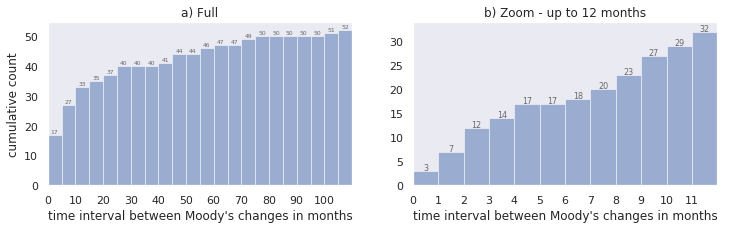

In [11]:
# cumulative hist plot for time intervals between Moody's announcements

sns.set(style="dark")

fig, axes = plt.subplots(1,2, figsize=(12,3))
axes = axes.ravel()

a = axes[0]

a.hist(df_moody_int.delta, bins=range(0,120, 5), cumulative=True, alpha=0.5)
a.set_xlabel("time interval between Moody's changes in months")
a.set_ylabel('cumulative count')
a.set_xlim([0,110])
a.set_title('a) Full')
a.set_xticks(range(0,110,10))
a.set_xticklabels(range(0,110,10))

# set individual bar lables
for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    if (i.get_x()<110) & (i.get_height()>0):
        a.text(i.get_x()+2.5, i.get_height()+0.5, str(int(i.get_height())), 
               fontsize=6, color='dimgrey', ha = 'center',
               rotation=0)

a = axes[1]

a.hist(df_moody_int.delta, bins=range(110), cumulative=True, alpha=0.5)
a.set_xlabel("time interval between Moody's changes in months")
a.set_xlim([0,12])
a.set_ylim([0,34])
a.set_title('b) Zoom - up to 12 months')
a.set_xticks(range(12))
a.set_xticklabels(range(12))

# set individual bar lables
for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    if (i.get_x()<12) & (i.get_height()>0):
        a.text(i.get_x()+0.5, i.get_height()+0.2, str(int(i.get_height())), 
               fontsize=8, color='dimgrey', ha = 'center',
               rotation=0)

# fig.suptitle("Distribution of intervals between Moody's changes", fontsize=12)

plt.show()
fig.savefig('fig_moodys_intervals_dist.pdf', bbox_inches='tight')

## Distribution of Moody's change type 

In [12]:
df_moody_count = pd.concat([df_moody_int, pd.get_dummies(df_moody_int['my_type'])], axis=1)

df_moody_count['all companies'] = ''

df_count_by_company = df_moody_count.groupby('Company').sum()
df_count_by_company = df_count_by_company.drop(['delta'], axis=1)

df_count_all = df_moody_count.groupby('all companies').sum()
df_count_all = df_count_all.drop(['delta'], axis=1)

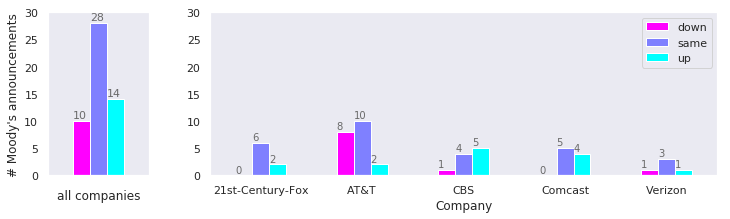

In [13]:
sns.set(style="dark")

fig, axes = plt.subplots(1,2, figsize=(12,3), gridspec_kw = {'width_ratios':[1, 5]})
axes = axes.ravel()

ax = axes[0]

df_count_all.plot(kind='bar', ax=ax, rot=0, colormap='cool_r')
ax.set_ylabel("# Moody's announcements")
ax.set_ylim([0, 30])

ax.get_legend().remove()

# bar lables
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+0.5, \
            str(i.get_height()), fontsize=11, color='dimgrey',
                rotation=0)

ax = axes[1]

df_count_by_company.plot(kind='bar', ax=ax, rot=0, colormap='cool_r')
ax.set_ylim([0, 30])

ax.set_xticklabels(list(sorted(sec_dict.keys())))

# bar lables
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+0.5, \
            str(i.get_height()), fontsize=10, color='dimgrey',
                rotation=0)

plt.show()
fig.savefig('Moody_counts.pdf', bbox_inches='tight')